# Problem set 7: Solving the consumer problem with income risk

In [125]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

C:\Users\jonas\AppData\Local\Temp\ipykernel_12760\1858130381.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Tasks

Solving the consumer problem is the **primary task** in this exercise set. You should spend most of the time you have on testing that you understand the different optimizers (problem I) and on solving the intertemporal consumption model (problem III). If for instance you are stuck in plotting, then skip ahead.   

## Optimization problem I

Consider the function

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) = (x_1^2 - x_1x_2 + x_2^2)^2
$$

Define it in **sympy** by:

In [126]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (x1**2 - x1*x2 + x2**2)**2

The **Jacobian** is

In [127]:
f1 = sm.diff(f,x1)
f2 = sm.diff(f,x2)
sm.Matrix([f1,f2])

Matrix([
[ (4*x_1 - 2*x_2)*(x_1**2 - x_1*x_2 + x_2**2)],
[(-2*x_1 + 4*x_2)*(x_1**2 - x_1*x_2 + x_2**2)]])

The **Hessian**  is

In [128]:
f11 = sm.diff(f,x1,x1)
f12 = sm.diff(f,x1,x2)
f21 = sm.diff(f,x2,x1)
f22 = sm.diff(f,x2,x2)
sm.Matrix([[f11,f12],[f21,f22]])

Matrix([
[      2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (2*x_1 - x_2)**2), 2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2))],
[2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2)),       2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (x_1 - 2*x_2)**2)]])

**Question A:** Lambdify $f(x_1,x_2)$ and use it to create: 

$(i)$ a 3D surfaceplot looking like this:

<img src="surfaceplot.png" 
     width="400" 
     height="500" />

$(ii)$ a contourplot looking like: 

<img src="contourplot.png" 
     width="400" 
     height="500" />

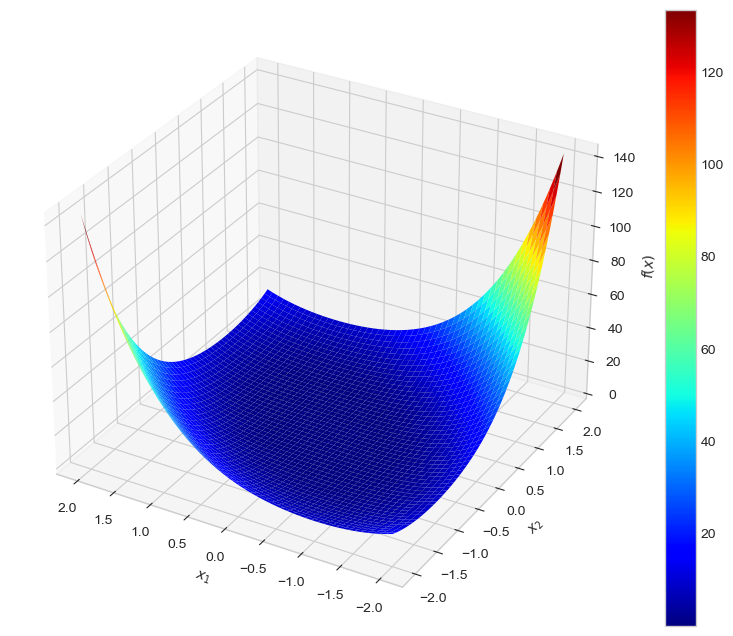

In [129]:
_f = sm.lambdify((x1,x2),f)

# write your code here
# Hint: use a np.meshgrid
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
_f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,_f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x)$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

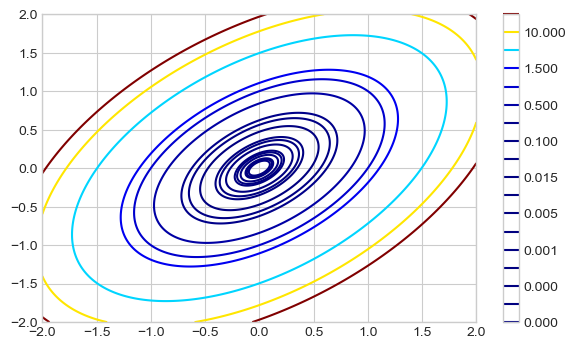

In [130]:
fig = plt.figure(dpi = 100, figsize=(7,4))
ax = fig.add_subplot(1,1,1)
levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
cs = ax.contour(x1_grid,x2_grid,_f_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Answer:** A1.py and A2.py

**Question B:** Construct python functions for the jacobian and the hessian.

In [131]:
# function for _f
f_python = lambda x: _f(x[0],x[1])

# write your code here

# jacobian
_f1 = sm.lambdify((x1,x2), f1)
_f2 = sm.lambdify((x1,x2), f2)

# hessian
_f11 = sm.lambdify((x1,x2), f11)
_f12 = sm.lambdify((x1,x2), f12)
_f21 = sm.lambdify((x1,x2), f21)
_f22 = sm.lambdify((x1,x2), f22)

# function for jacobian
def f_jac(x):
    return np.array([_f1(x[0],x[1]),_f2(x[0],x[1])])

# function for hessian
def f_hess(x):
    row1 = [_f11(x[0],x[1]),_f12(x[0],x[1])]
    row2 = [_f21(x[0],x[1]),_f22(x[0],x[1])]
    return np.array([row1,row2])


**Answer:** A3.py

**Question C:** Minimize $f(x_1,x_2)$ using respectively

1. Nelder-Mead,
2. BFGS without analytical jacobian,
3. BFGS with analytical jacobian, and
4. Newton-CG with analytical jacobian and hessian

Compare the results and discuss which optimizer you prefer.

**Optional:** If you wish, you can use the functions defined in the hidden cells below to also track how the optimizers converges to the solution.

In [132]:
def collect(x):
    
    # globals used to keep track across iterations
    global evals # set evals = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [f_python(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(f_python(x))
    
    # c. increment number of evaluations
    evals += 1

In [133]:
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
    cs = ax.contour(x1_grid,x2_grid,_f_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

1. Nelder-Mead:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 83


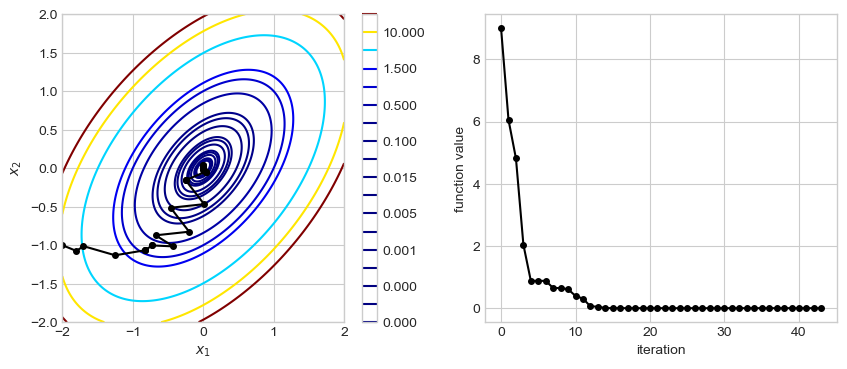

In [134]:
x0 = [-2,-1] # suggested initial guess

# write your code here

evals = 0 # global used in "collect"

result = optimize.minimize(f_python,x0,
                           method='Nelder-Mead',
                           callback=collect, # call function collect() before each iteration
                           options={'disp':True}) # display the results
contour()

**Answer:** A4.py, A5.py, A6.py, A7.py

2. BFGS without analytical jacobian:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 84
         Gradient evaluations: 28


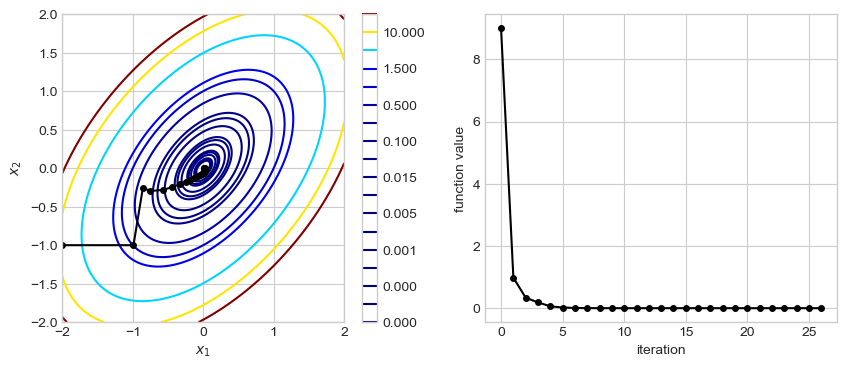

In [135]:
x0 = [-2,-1] # suggested initial guess
evals = 0 # global used in "collect"

# write your code here
result = optimize.minimize(f_python,x0, # no jac= specified
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

3. BFGS with analytical jacobian


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28


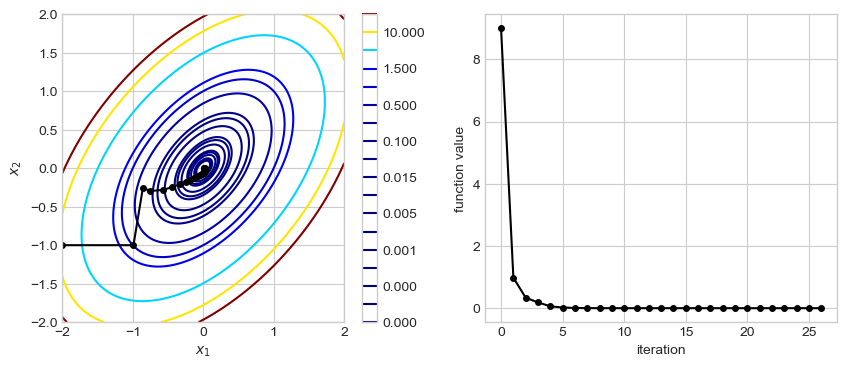

In [136]:
x0 = [-2,-1] # suggested initial guess
evals = 0 # global used in "collect"

# write your code here
result = optimize.minimize(f_python,x0,jac=f_jac,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

4. Newton-CG with analytical jacobian and hessian:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 15
         Gradient evaluations: 15
         Hessian evaluations: 15


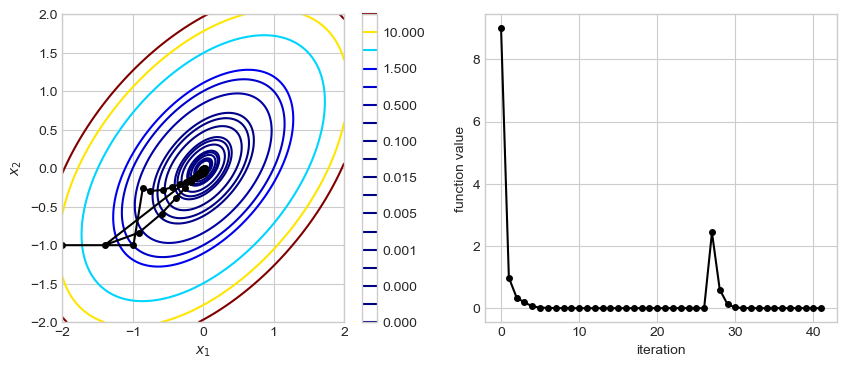

In [137]:
result = optimize.minimize(f_python,x0,jac=f_jac,hess=f_hess,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

## Optimization problem II

Consider the function

$$
f(x_1,x_2) = (4-2.1x_1^2 + \frac{x_1^4}{3})x_1^2 + x_1x_2 + (4x_2^2 - 4)x_2^2)
$$

Define it in **sympy** by:

In [138]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (4-2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (4*x2**2 - 4)*x2**2
_f = sm.lambdify((x1,x2),f)
f

x_1**2*(x_1**4/3 - 2.1*x_1**2 + 4) + x_1*x_2 + x_2**2*(4*x_2**2 - 4)

Create **3D plot**:

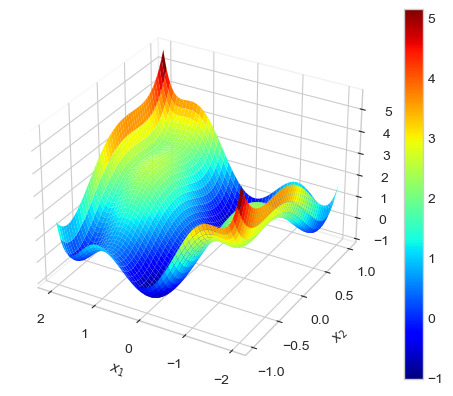

In [139]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-1,1,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. add colorbar
fig.colorbar(cs);

**Question A:** Find the minimum of the function starting from each of the suggested initial values below. Print the first 20 solutions, and all solutions aftwards, which is the best yet to be found. Save the solutions and associated function values in `xs` and `fs`.

In [140]:
# a. python function for f
f_python = lambda x: _f(x[0],x[1])

# b. initial guesses
np.random.seed(1986)
K = 1000
x0s = np.empty((K,2))
x0s[:,0] = -2 + 4*np.random.uniform(size=K)
x0s[:,1] = -1 + 2*np.random.uniform(size=K)

# c. solutions and associated values
xs = np.empty((K,2))
fs = np.empty(K)

# write your code here
fopt = np.inf
xopt = np.nan

for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(f_python,x0,method='BFGS')
    xs[i,:] = result.x
    fs[i] = result.fun
    
    # b. print first 20 or if better than seen yet
    if i < 20 or fs[i] < fopt: # plot 20 first or if improving
        if fs[i] < fopt:
            xopt = xs[i,:]
            fopt = fs[i]
        print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[0]:6.2f})',end='')
        print(f' -> converged at ({xs[i][0]:6.2f},{xs[i][1]:6.2f}) with f = {fs[i]:.12f}')
        
# best solution
print(f'\nbest solution:\n x = ({xopt[0]:6.2f},{xopt[1]:6.2f}) -> f = {fopt:.12f}')

   0: x0 = (  0.28,  0.28) -> converged at (  0.09, -0.71) with f = -1.031628453485
   1: x0 = ( -1.69, -1.69) -> converged at ( -1.70,  0.80) with f = -0.215463824384
   2: x0 = (  0.43,  0.43) -> converged at (  0.09, -0.71) with f = -1.031628453490
   3: x0 = (  1.59,  1.59) -> converged at (  1.70, -0.80) with f = -0.215463824384
   4: x0 = (  0.18,  0.18) -> converged at (  0.09, -0.71) with f = -1.031628453490
   5: x0 = (  0.81,  0.81) -> converged at ( -0.09,  0.71) with f = -1.031628453490
   6: x0 = ( -0.46, -0.46) -> converged at ( -0.09,  0.71) with f = -1.031628453487
   7: x0 = (  0.61,  0.61) -> converged at (  0.09, -0.71) with f = -1.031628453490
   8: x0 = (  0.76,  0.76) -> converged at ( -0.09,  0.71) with f = -1.031628453484
   9: x0 = (  0.87,  0.87) -> converged at ( -0.09,  0.71) with f = -1.031628453490
  10: x0 = (  0.76,  0.76) -> converged at ( -0.09,  0.71) with f = -1.031628453489
  11: x0 = (  1.23,  1.23) -> converged at (  1.70, -0.80) with f = -0.21546

**Answer:** A8.py

**Question B:** Create a 3D scatter plot of where the optimizer converges, and color the dots by the associated function values.

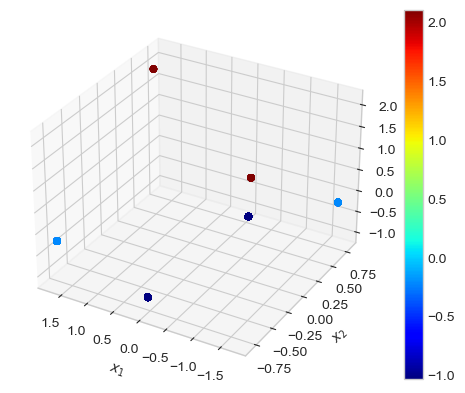

In [141]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(xs[:,0],xs[:,1],fs,c=fs,cmap=cm.jet);        

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# c. invert xaxis
ax.invert_xaxis()

# d. colorbar
fig.colorbar(cs);

**Answer:** A9.py

**Question C:** Plot the function values at the solutions as a function of the starting values.

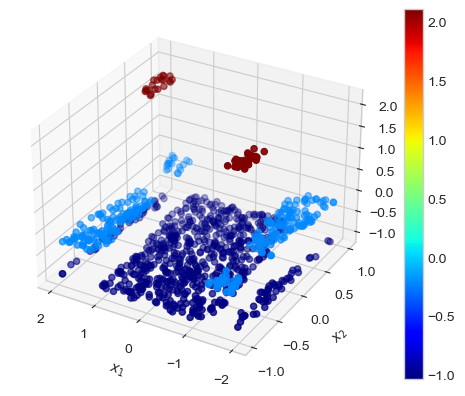

In [142]:
# write your code here
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(x0s[:,0],x0s[:,1],fs,c=fs,cmap=cm.jet);        

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# c. invert xaxis
ax.invert_xaxis()

# d. colorbar
fig.colorbar(cs);

**Answer:** A10.py

# Problem: Solve the consumer problem with income risk I

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is consumption in period $t$
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
 \text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) & = 
\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right] \\
\text{s.t.} \\
m_2 &= (1+r)(m_{1}-c_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

The **basic functions** are:

In [143]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

The **solution functions** are:

In [144]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda x: -v2(x[0],m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x[0]
        
    return m2_vec,v2_vec,c2_vec

def solve_period_1(rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],m1,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1/2
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m1),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return m1_vec,v1_vec,c1_vec

**Question A:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it.

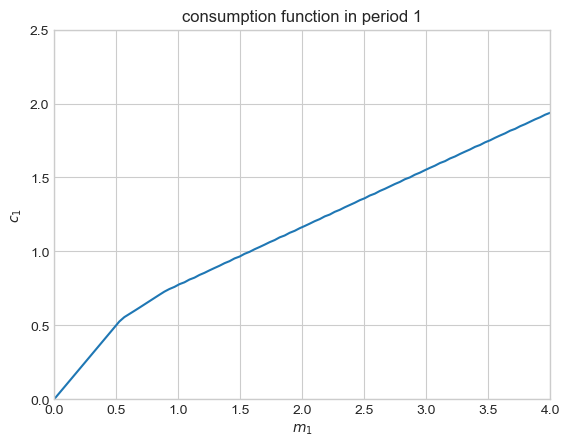

In [145]:
rho = 8
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

# b. solve
def solve(rho,beta,r,Delta,nu,kappa,v1):
    
    # a. solve for period 2
    m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)

    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator((m2_vec,), v2_vec, bounds_error= False, fill_value = False)

    # c. solve for period 1
    m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v1,v2_interp)

    return m1_vec, c1_vec


m1_vec,c1_vec = solve(rho,beta,r,Delta,nu,kappa,v1)

# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);



**Answer:** A11.py

**Question B:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it, assuming that

$$ 
y_{2} = \begin{cases}
1-\sqrt{\Delta} & \text{with prob. }0.1\\
1-\Delta & \text{with prob. }0.4\\
1+\Delta & \text{with prob. }0.4\\ 
1+\sqrt{\Delta} & \text{with prob. }0.1
\end{cases}
$$

which add some low probability tail events, but does not change mean income. Give an interpretation of the change in the consumption function.

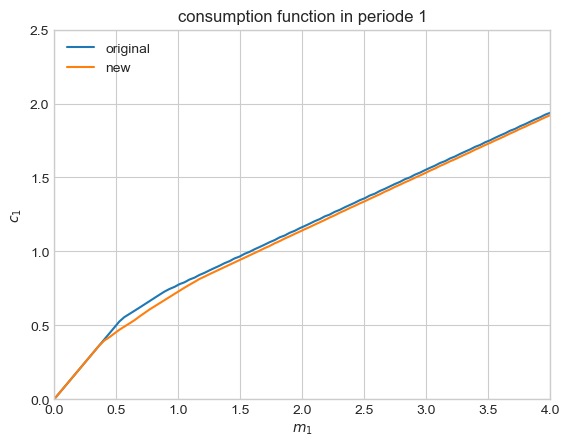

In [146]:
def v1_alt(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. expected v2 value
    Ra = (1+r)*(m1-c1)
    v2 = 0
    y2s = [1-np.sqrt(Delta),1-Delta,1+Delta,1+np.sqrt(Delta)]
    probs = [0.1,0.4,0.4,0.1]
    for y2,prob in zip(y2s,probs):
        m2 = Ra + y2
        v2 += prob*v2_interp([m2])[0]
        
    # b. total value
    return utility(c1,rho) + beta*v2

m1_vec_alt,c1_vec_alt = solve(rho,beta,r,Delta,nu,kappa,v1_alt)

# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec,label='original')
ax.plot(m1_vec_alt,c1_vec_alt,label='new')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in periode 1')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

The consumer is riskaverse, thus introducing more extreme events decreases spending.

**Answer:** A12.py

# Problem: Solve the consumer problem with income risk II

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is non-durable consumption in period $t$
* $d_t$ is durable consumption in period $t$ (only adjustable in period 1)
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\alpha \in (0,1)$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2},d_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\alpha\frac{d_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}+d_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
\text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) &= \max_{c_{1},d_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\alpha\frac{d_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2,d_2)\right]\\&\text{s.t.}&\\
m_2 &= (1+r)(m_{1}-c_{1}-d_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1}+d_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

Choose **parameters**:

In [147]:
rho = 2
alpha = 0.1
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

# b. solve
# write your code here

# c. plot
# write your code here

The **basic functions** are:

In [148]:
def utility(c,d,alpha,rho):
    return c**(1-rho)/(1-rho) + alpha*d**(1-rho)/(1-rho)

def bequest(m,c,d,nu,kappa,rho):
    return nu*(m+d-c+kappa)**(1-rho)/(1-rho)

def v2(c2,d2,m2,alpha,rho,nu,kappa):
    return utility(c2,d2,alpha,rho) + bequest(m2,c2,d2,nu,kappa,rho)

def v1(c1,d1,m1,alpha,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1-d1) + 1-Delta
    v2_low = v2_interp([m2_low,d1])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1-d1) + 1+Delta
    v2_high = v2_interp([m2_high,d1])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,d1,alpha,rho) + beta*v2

The **solution function for period 2** is:

In [149]:
def solve_period_2(alpha,rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,200)
    d2_vec = np.linspace(1e-6,5,100)
    v2_grid = np.empty((200,100))
    c2_grid = np.empty((200,100))

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d2 in enumerate(d2_vec):

            # i. objective
            obj = lambda x: -v2(x[0],d2,m2,alpha,rho,nu,kappa)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x[0]
        
    return m2_vec,d2_vec,v2_grid,c2_grid

**Question A:** Solve for consumption in period 2 and plot the consumption function.

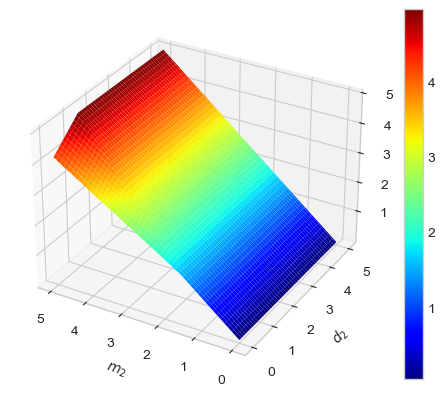

In [150]:
# write your code here
# a. solve
m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha,rho,nu,kappa,Delta)

# b. grids
m2_grid,d2_grid = np.meshgrid(m2_vec,d2_vec,indexing='ij')

# c. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d2_grid,c2_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d_2$')
ax.set_zlabel('$c_2$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

**Answer:** A13.py

**Question B:** Find optimal consumption and choices of durables in the first period as a function of cash-on-hand and plot it.

c:\Users\jonas\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


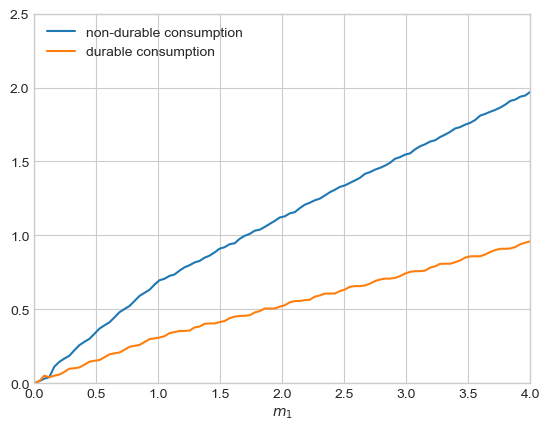

In [152]:
# write your code here
# a. define solve function
def solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-4,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    d1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],x[1],m1,alpha,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess
        x0 = [m1*1/3,m1*1/3]
        
        # iii. bounds and constraitns
        bound = (1e-8,m1-1e-8)
        bounds = (bound, bound)
        ineq_con = {'type': 'ineq', 'fun': lambda x: m1-x[0]-x[1]} 
        
        # iv. optimize
        result = optimize.minimize(obj,x0, method='SLSQP',
                                   bounds=bounds,
                                   constraints=[ineq_con])
        
        # v. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
        d1_vec[i] = result.x[1]
     
    return m1_vec,v1_vec,c1_vec,d1_vec

# b. construct interpolator
v2_interp = interpolate.RegularGridInterpolator((m2_vec,d2_vec), v2_grid,
                                                bounds_error=False,fill_value=None)
    
# c. solve period 1
m1_vec,v1_vec,c1_vec,d1_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp)

# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec,label='non-durable consumption')
ax.plot(m1_vec_alt,d1_vec,label='durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

**Answer:** A14.py

# Extra Problems

**Simulate** a distribution of consumers in either of the two consumption-saving models above. See **section 6.3 in lecture 11** regarding 
how this is done.